In [591]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import reedsolo as rs
import math

In [223]:
def find_qr_code_zone(img, error_tolerance):
    
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    for row_index, row in enumerate(img):
        for pixel in row:
            if pixel != 255:
                start_row = row_index
                break
        if start_row != -1:
            break

    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break
    qr_no_quiet_zone = img[start_row+error_tolerance:end_row-error_tolerance, start_col+error_tolerance:end_col-error_tolerance]
    return qr_no_quiet_zone

In [520]:
def find_cell_size(qr_code):

    # size = 0
    # # Find the width of the top left finder
    # for pixel in qr_code[0]:
    #     if (pixel != 0): break
    #     size += 1
    # # Therefore the grid cell size is..
    # grid_cell_size = round(size/7)

    # The width of the qr code should be 21 cells, thus
    grid_cell_size = round(qr_code.shape[0]/21)

    print(f"cell size: {grid_cell_size}")
    return grid_cell_size

In [7]:
def find_size_in_cells(qr_code, cell_size):
    return round(qr_code.shape[0]/cell_size)

In [609]:
def split_into_cells(qr_no_quiet_zone, grid_cell_size, grid_cells_num):

    print(f"size of input to split_into_cells: {qr_no_quiet_zone.shape}")
    s = grid_cells_num * grid_cell_size
    w,h = qr_no_quiet_zone.shape[:2]

    # Resize the image so that width is equal to height
    new_size = max(w, h)
    # Calculate the scaling factor
    # scaling_factor = new_size / max(height, width)
    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(qr_no_quiet_zone, (new_size,new_size))
    # print('Resized\n', resized_image)
    w,h = resized_image.shape[:2]

    # Apply replicate padding if needde
    # Find the optimal padding value
    padding = 0
    while((w+ 2*padding) < s): padding += 2
    padded_image = cv2.copyMakeBorder(resized_image, padding, padding, padding, padding, borderType=cv2.BORDER_REPLICATE)
    print(f"size of input to the reshape part : {resized_image.shape}\nshape: {s}\npadding: {padding}")

    # Finding the padded qr_code to ,be resized
    width_middle = (2*padding + w)//2
    height_middle = (2*padding + h)//2
    # print(f"size of padded_image[:shape, :shape] : {padded_image[:s, :s].shape}")

    # qr_cells = padded_image[ math.ceil(width_middle-(s/2)) : math.ceil(width_middle+(s/2)) , math.ceil(height_middle-(s/2)) : math.ceil(height_middle+(s/2))].reshape((
    qr_cells = padded_image[:s, :s].reshape((
        grid_cells_num,
        grid_cell_size,
        grid_cells_num,
        grid_cell_size,
    )).swapaxes(1, 2)
    
    return qr_cells

In [9]:
def convert_to_numeric_and_inv(qr_cells, grid_cells_num):
    
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = 1 - (np.median(cell) // 255)

    return qr_cells_numeric

In [684]:
def image_to_qr_numeric(img):
    
    # Find the part of the image with the qr-code
    qr_no_quiet_zone = find_qr_code_zone(img, 0)
    # Crop the output further from a more accurate outline of the qr code
    # by searching diagonaly for the first black pixel
    t = 0
    j = 0
    for i in range(qr_no_quiet_zone.shape[0]):
        if qr_no_quiet_zone[i, j] == 0: break
        t += 1
        j += 1 
    qr_no_quiet_zone = find_qr_code_zone(qr_no_quiet_zone, t)


    # Find the size of each cell in pixels and the number of pixels
    grid_cell_size = find_cell_size(qr_no_quiet_zone) 
    grid_cells_num = find_size_in_cells(qr_no_quiet_zone, grid_cell_size)

    # Split the qr-code in-terms of cells
    qr_cells = split_into_cells(qr_no_quiet_zone, grid_cell_size, grid_cells_num)

    # Convert the qr-code into numeric data and invert the values
    qr_cells_numeric = convert_to_numeric_and_inv(qr_cells, grid_cells_num)

    # PLOTTING!!!!!
    # _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
    # for i, row in enumerate(axes):
    #     for j, col in enumerate(row):
    #         col.imshow(qr_cells[i][j], cmap="gray", vmin=0, vmax=255)
    #         col.get_xaxis().set_visible(False)
    #         col.get_yaxis().set_visible(False)
    #         col.spines[:].set_color('red')

    return qr_cells_numeric


cell size: 44
size of input to split_into_cells: (914, 915)
size of input to the reshape part : (915, 915)
shape: 924
padding: 6


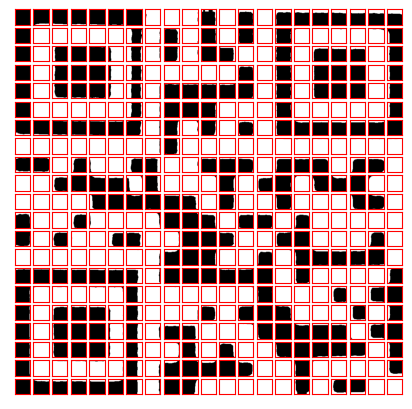

In [624]:
#Testing 
from correction import rotation_correction, translation_correction

img_1 = cv2.imread('images/14-solved-2.png', cv2.IMREAD_GRAYSCALE)

# cont= rotation_correction(img_1)

qr_cells_numeric = image_to_qr_numeric(img_1)
# print(qr_cells_numeric)

# qr_no_quiet_zone = find_qr_code_zone(img_1, 1)

# # Crop the output further from a more accurate outline of the qr code
# # by searching diagonaly for the first black pixel
# t = 0
# j = 0
# for i in range(qr_no_quiet_zone.shape[0]):
#     if qr_no_quiet_zone[i, j] == 0: break
#     t += 1
#     j += 1 
# qr_no_quiet_zone = find_qr_code_zone(qr_no_quiet_zone, t)

# # grid_cell_size = find_cell_size(qr_no_quiet_zone) 

# print(qr_no_quiet_zone)

# plt.imshow(qr_no_quiet_zone, cmap='gray')

# plt.imshow(cont, cmap='gray')
# print(cont)

In [24]:
def find_ecl(qr_cells_numeric, from_columns = True):
# Finds ecl, if the from_columns is true it finds it from the 9th column else use teh 9th row #
    if from_columns:
        row = np.flip(qr_cells_numeric[:, 8])
    else:
        row = qr_cells_numeric[8]

    ecl = [int(c) for c in row[0:2]]
    return ecl

In [100]:
def find_ecl_int(ecl):
    
    if ecl == [1, 1]:
        return 7
    elif ecl == [1, 0]:
        return 15
    elif ecl == [0, 1]:
        return 25
    elif ecl == [0,0]:
        return 30
    else:
        return -1


In [76]:
def find_mask (qr_cells_numeric, from_columns=True):
# Finds mask, if the from_columns is true it finds it from the 9th column else use teh 9th row #
        if from_columns:
            row = np.flip(qr_cells_numeric[:, 8])
        else:
            row = qr_cells_numeric[8]

        mask = [int(c) for c in row[2:5]]
        return mask

MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

In [18]:
def find_fec(qr_cells_numeric):
    fec = []
    fec.append(qr_cells_numeric[8, 5])
    fec.append(qr_cells_numeric[8, 7])
    fec.extend(qr_cells_numeric[0:6, 8])
    fec.extend(qr_cells_numeric[7:9, 8])
    fec = [int(c) for c in fec]
    return fec

In [74]:
def find_ecl_mask_fec(qr_cells_numeric):

    ecl = find_ecl(qr_cells_numeric= qr_cells_numeric)
    mask = find_mask(qr_cells_numeric= qr_cells_numeric)
    fec = find_fec(qr_cells_numeric= qr_cells_numeric)

    # ecl[0] ^= 1
    # mask[0] ^= 1
    # mask[2] ^= 1
    # fec[5] ^= 1
    # fec[8] ^= 1

    return ecl, mask, fec

In [75]:
# Test #
ecl, mask, fec = find_ecl_mask_fec(qr_cells_numeric= qr_cells_numeric)
print(ecl, mask, fec)

[1, 1] [0, 1, 0] [0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


In [32]:
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

def apply_mask(data_start_i, data_start_j, data, mask, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [46]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [682]:
def decode_image(image):

    
    # Find numeric qr-code
    qr_cells_numeric = image_to_qr_numeric(image)
    
    grid_cell_num = qr_cells_numeric.shape[0]
    print(f"number of cells: {grid_cell_num}")

    # Find mask 
    ecl, mask, fec = find_ecl_mask_fec(qr_cells_numeric= qr_cells_numeric)
    print(f"ecl: {ecl}\nmask: {mask}\nfec: {fec}")

    # Find enc_bits and len_bits and len_int
    enc_bits = apply_mask(grid_cell_num-1, grid_cell_num-1,qr_cells_numeric , mask, UP4)
    len_bits = apply_mask(grid_cell_num-3, grid_cell_num-1, qr_cells_numeric , mask, UP8)
    len_int = int(''.join([str(bit) for bit in len_bits]), 2)
    print(f"enc_bit: {enc_bits}\nlen_bits: {len_bits}\nlen_int: {len_int}")

    message_bits = []
    message_bits.extend(enc_bits)
    message_bits.extend(len_bits)


#####################################################################################################################
    
    # First, let's read the data bytes, starting from the very first byte after enc and len
    byte_index = 0
    for _ in range(25):
        
        start_i, start_j, dir = block_starting_indices[byte_index]
        bits = apply_mask(start_i, start_j, qr_cells_numeric, mask, dir)
        message_bits.extend(bits)
        bit_string = ''.join([str(bit) for bit in bits])
        alpha_char = chr(int(bit_string, 2))
        print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
        byte_index += 1

    # # After finishing all the characters, the next 4 bits are expected to be '0000'
    # start_i, start_j, dir = block_starting_indices[byte_index]
    # bits = apply_mask(start_i, start_j, qr_cells_numeric, mask, dir)
    # message_bits.extend(bits)
    # bit_string = ''.join([str(bit) for bit in bits])
    # print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
    # byte_index += 1

    # # Let's see what the bytes that follow look like
    # # There supposedly remain 25-len-1 bytes to be read
    # for _ in range(25 - len_int - 1):
    #     start_i, start_j, dir = block_starting_indices[byte_index]
    #     bits = apply_mask(start_i, start_j, qr_cells_numeric, mask, dir)
    #     message_bits.extend(bits)
    #     bit_string = ''.join([str(bit) for bit in bits])
    #     alpha_char = chr(int(bit_string, 2))
    #     print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    #     byte_index += 1
#####################################################################################################################
    # For every 8 bits in the extracted message, convert to a byte
    message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]

    # Map ECL from bits to int
    ecl_int = find_ecl_int(ecl)
    print(f"ecl_int: {ecl_int}")
    # Create the Reed-Solomon Codec for 7 ECC symbols (again, this is L)
    rsc = rs.RSCodec(nsym=ecl_int)

    # Decode the bytes with the 7-ECC RS Codec
    message_decoded = rsc.decode(message_bytes)
    rsc.maxerrata(verbose=True)

    
    # Decode for the approptiate encoding 
    if enc_bits == [0, 0, 1, 0]: # Alphanumerical
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+(len_int)*11]
        msg = ""
        for i in range(0, len(data_bits), 11):
            bits_string = data_bits[i:i+11]
            int_val = int(bits_string, 2)
            lhs = chr(55+(int_val//45)) if chr(55+(int_val//45)) != '[' else ' '
            rhs = chr(55+(int_val%45)) if chr(55+(int_val%45)) != '[' else ' '
            msg += lhs
            msg += rhs
        #print('sssss', msg)
        return msg
    else:
        data_bits = bin(int.from_bytes(message_decoded[0], byteorder='big'))[13:13+len_int*8]
            # Now convert back to bytes and return it
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        return data_bytes.decode(encoding="iso-8859-1")


In [696]:
# Testing #
img_1 = cv2.imread('images/15-solved.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(img_1, cmap='gray')
msg = decode_image(img_1)
print(msg)

cell size: 10
size of input to split_into_cells: (200, 201)
size of input to the reshape part : (201, 201)
shape: 200
padding: 0
number of cells: 20
ecl: [1, 1]
mask: [0, 0, 1]
fec: [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
enc_bit: [0, 0, 0, 0]
len_bits: [1, 1, 1, 1, 0, 0, 0, 0]
len_int: 240


IndexError: index 20 is out of bounds for axis 1 with size 20